In [1]:
!pip -q install roboflow
!pip -q install ultralytics==8.0.200
!pip install -U ipywidgets
! pip -q install ruamel.yaml
! wget https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m-seg.pt

from roboflow import Roboflow
import sys
import ruamel.yaml
from ultralytics import YOLO
from pathlib import Path
import os
from collections import defaultdict
import copy
import math
import shutil
import numpy as np
import psutil
import gc
import matplotlib.pyplot as plt
import locale
from IPython.display import clear_output
import ctypes
import ctypes.util
import torch
import random
from ultralytics.utils import SETTINGS


SETTINGS['wandb'] = False

os.environ['WANDB_DISABLED'] = 'true'
# deterministic set
torch.manual_seed(43)
random.seed(43)
np.random.seed(43)


rf = Roboflow(api_key="tD9RSesaXxGqmwVD6eVZ")
project = rf.workspace("lasttest-6gwfw").project("fire_smoke-tfcpd")
dataset = project.version(9).download("yolov8")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.0.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.1 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.1 requires jupyterlab<5.0.0a0,>=4.0.6, but you have jupyterlab 4.0.5 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pytoolconfig 1.2.6 requires packaging>=22.0, but you have packaging 21.3 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tensorflowjs 4.14.0 requires packaging~=23.1,

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.200, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to fire_smoke-9 in yolov8:: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25886/25886 [00:03<00:00, 7408.38it/s] 


In [2]:
! pip show torch
! pip show ultralytics

Name: torch
Version: 2.0.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /opt/conda/lib/python3.10/site-packages
Requires: filelock, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, catalyst, easyocr, fastai, kornia, pytorch-ignite, pytorch-lightning, stable-baselines3, thop, timm, torchaudio, torchdata, torchmetrics, torchtext, torchvision, ultralytics
Name: ultralytics
Version: 8.0.200
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://github.com/ultralytics/ultralytics
Author: Ultralytics
Author-email: hello@ultralytics.com
License: AGPL-3.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: matplotlib, numpy, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, thop

In [3]:
%cd /kaggle/working/fire_smoke-9

# trying to optimize RAM usage
gc.enable()

libc = ctypes.CDLL(ctypes.util.find_library('c'))
libc.malloc_trim(ctypes.c_int(0))

torch.set_num_threads(1)
os.environ["OMP_NUM_THREADS"] = "1"

/kaggle/working/fire_smoke-9


In [4]:
class YoloModel:
    def __init__(self, path_to_model: str, path_to_yaml: str,
                 train_perc: float, test_perc: float, val_perc: float,
                 ttvs_flag = 0, tp_flag = 0):
        """–ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö

        Args:
            path_to_model (str): –ø—É—Ç—å –¥–æ –≤–µ—Å–æ–≤ yolov8.pt
            path_to_yaml (str): –ø—É—Ç—å –¥–æ data.yaml —Ñ–∞–π–ª–∞ –¥–∞—Ç–∞—Å–µ—Ç–∞
            train_perc (float): –¥–æ–ª—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö 
            test_perc (float): –¥–æ–ª—è —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö
            val_perc (float): –¥–æ–ª—è –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
        """        
        self.path_to_model = path_to_model
        self.path_to_yaml = path_to_yaml
        self.train_path = Path('train') if os.path.exists(Path('train')) else None
        self.test_path = Path('test') if os.path.exists(Path('test')) else None
        self.val_path = Path('valid') if os.path.exists(Path('valid')) else None
        self.train_perc = train_perc
        self.test_perc = test_perc
        self.val_perc = val_perc
        
        self.ttvs_flag = ttvs_flag
        self.tp_flag = tp_flag
        
        self.ram_usage = []
        
        assert self.train_path != None, '–î–∏—Ä–µ–∫—Ç–æ—Ä–∏—è train –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç'
        if (self.val_path == None):
            os.mkdir("valid", mode=0o777)
            os.mkdir("valid/images", mode=0o777)
            os.mkdir("valid/labels", mode=0o777)
            self.val_path = Path("valid")
        if (self.test_path == None):
            os.mkdir("test", mode=0o777)
            os.mkdir("test/images", mode=0o777)
            os.mkdir("test/labels", mode=0o777)
            self.test_path = Path("test")
    
    def get_ram_usage(self,):
        """Gets the current RAM usage of the system.

        Returns:
            float: RAM usage in GB.
        """
        return psutil.virtual_memory().used / 1e9

    def train(self, folder_name: str, iters: int) -> YOLO: 
        """–ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏ –∏ –æ–±—É—á–µ–Ω–∏–µ

        Args:
            folder_name (str): –Ω–∞–∑–≤–∞–Ω–∏–µ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–∏ —Å —á–∞—Å—Ç—å—é –¥–∞–Ω–Ω—ã—Ö
            iters (int): –∫–æ–ª-–≤–æ –∏–Ω—Ç–µ—Ä–∞—Ü–∏–π

        Returns:
            YOLO: —ç–∫–∑–µ–º–ø–ª—è—Ä –æ–±—É—á–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏
        """        
        # –ö–æ—Ä—Ä–µ–∫—Ç–∏—Ä—É–µ–º data.yaml —Ñ–∞–π–ª
        yaml = ruamel.yaml.YAML()
        # yaml.preserve_quotes = True
        with open("data.yaml", 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = './'+folder_name+'/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        self.ram_usage.append(self.get_ram_usage())
        model = YOLO(self.path_to_model)
        model.train(
            # Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,
            plots = False)
        
        return model
    
    def retrain(self, folder_name: str, iters: int,) -> YOLO:
        """–û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –Ω–∞ –≤—Å–µ—Ö –ø—Ä–µ–¥—ã–¥—É—â–∏—Ö —á–∞—Å—Ç—è—Ö –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –ø—Ä–æ—Ñ–∏–ª–∞–∫—Ç–∏ –ø—Ä–æ—Å–∞–¥–∫–∏ –º–µ—Ç—Ä–∏–∫–∏

        Args:
            folder_name (str): –Ω–∞–∑–≤–∞–Ω–∏–µ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–∏ —Å —á–∞—Å—Ç—å—é –¥–∞–Ω–Ω—ã—Ö
            iters (int): –∫–æ–ª-–≤–æ –∏–Ω—Ç–µ—Ä–∞—Ü–∏–π

        Returns:
            YOLO: —ç–∫–∑–µ–º–ø–ª—è—Ä –æ–±—É—á–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏
        """        
        os.mkdir("retrain", mode=0o777)
        os.mkdir("retrain/train", mode=0o777)
        os.mkdir("retrain/train/images", mode=0o777)
        os.mkdir("retrain/train/labels", mode=0o777)

        # —Å–æ–±–∏—Ä–∞–µ–º —Å–ø–∏—Å–æ–∫ –≤—Å–µ—Ö –∫—É—Å–∫–æ–≤ –¥–∞–Ω–Ω—ã—Ö –¥–æ –Ω–∞—à–µ–≥–æ folder_name
        folder_num = np.arange(1, int(folder_name.split('_')[-1]) + 1)
        cls = folder_name.split("_")[1]
        source_pathes = [f"temp_{cls}_{i}" for i in folder_num]

        # –∫–æ–ø–∏—Ä—É–µ–º –≤—Å–µ —Å–æ–±—Ä–∞–Ω–Ω—ã–µ –∫—É—Å–∫–∏ –¥–∞–Ω–Ω—ã—Ö –≤ –ø–∞–ø–∫—É retrain
        for path in source_pathes:
            # —Å–æ–±–∏—Ä–∞–µ–º –≤—Å–µ —Ñ–∞–π–ª—ã
            all_images_train = os.listdir(path+"/train/images")
            all_labels_train = os.listdir(path+"/train/labels")

            for image in all_images_train:
                shutil.copyfile(path+"/train/images/" + image,
                                "retrain/train/images/" + image)
            for label in all_labels_train:
                shutil.copyfile(path+"/train/labels/" + label,
                                "retrain/train/labels/" + label)

        # –ö–æ—Ä—Ä–µ–∫—Ç–∏—Ä—É–µ–º data.yaml —Ñ–∞–π–ª
        yaml = ruamel.yaml.YAML()
        with open("data.yaml", 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = 'retrain/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        
        self.ram_usage.append(self.get_ram_usage())
        # load a pretrained model (recommended for training)
        model = YOLO(self.path_to_model)
        model.train(# Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,
            plots = False)
        
        return model
    
    def test(self, folder_name: str, model: YOLO):
        """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏

        Args:
            model (YOLO): —ç–∫–∑–µ–º–ø–ª—è—Ä –æ–±—É—á–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏

        Returns:
            _type_: _description_
        """        
        # –ö–æ—Ä—Ä–µ–∫—Ç–∏—Ä—É–µ–º data.yaml —Ñ–∞–π–ª
        yaml = ruamel.yaml.YAML()
        with open("data.yaml", 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = 'retrain/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
            
        metrics = model.val(data=self.path_to_yaml, split="test")
        return metrics
    
    def train_test_val_split(self, keep_perc: float):
        """–†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –∏–∑–Ω–∞—á–∞–ª—å–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞ –Ω–∞ –∑–∞–¥–∞–Ω–Ω—ã–µ –¥–æ–ª–∏ train/test/val. –£–¥–∞–ª–µ–Ω–∏–µ 1-keep_perc –¥–æ–ª–∏ –¥–∞–Ω–Ω—ã—Ö 

        Args:
            keep_perc (float): –¥–æ–ª—è –¥–∞–Ω–Ω—ã—Ö, –∫–æ—Ç–æ—Ä—É—é –Ω—É–∂–Ω–æ –æ—Å—Ç–∞–≤–∏—Ç—å
        """        
        # —Å–æ–∑–¥–∞–µ–º –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–∏ –¥–ª—è –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è –≤—Å–µ—Ö —Ñ–∞–π–ª–æ–≤
        os.mkdir("temp", mode=0o777)
        os.mkdir("temp/images", mode=0o777)
        os.mkdir("temp/labels", mode=0o777)
            
        source_pathes = (self.train_path / 'images', self.train_path / 'labels',\
                        self.test_path / 'images', self.test_path / 'labels',\
                        self.val_path / 'images', self.val_path / 'labels',)
        destination = Path('temp')

        for path in source_pathes:
            # —Å–æ–±–∏—Ä–∞–µ–º –≤—Å–µ —Ñ–∞–π–ª—ã
            allfiles = os.listdir(path)
            # –∏—Ç–µ—Ä–∏—Ä—É–µ–º –ø–æ –≤—Å–µ–º —Ñ–∞–π–ª–∞–º, —á—Ç–æ–±—ã –ø–µ—Ä–µ–º–µ—Å—Ç–∏—Ç—å –∏—Ö –≤ –ø–∞–ø–∫—É –Ω–∞–∑–Ω–∞—á–µ–Ω–∏—è
            sub_folder = path.name # images or labels
            for f in allfiles:
                src_path = os.path.join(path, f)
                dst_path = os.path.join(destination / sub_folder, f)
                os.rename(src_path, dst_path)
        total_num = len(allfiles)
        # –°–æ–∑–¥–∞–µ–º —Å–ª–æ–≤–∞—Ä—å, –≥–¥–µ –∫–ª—é—á - –º–µ—Ç–∫–∞ –∫–ª–∞—Å—Å–∞, –∑–Ω–∞—á–µ–Ω–∏–µ - –º–Ω–æ–∂–µ—Å—Ç–≤–æ –ø—É—Ç–µ–π –∫ label —Ñ–∞–π–ª–∞–º –¥–∞–Ω–Ω–æ–≥–æ –∫–ª–∞—Å—Å–∞
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("temp/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # –ö–∞–∂–¥–æ–º—É –æ–±—ä–µ–∫—Ç—É –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–∏ —Å–æ–æ—Ç–≤–µ—Å—Ç–≤—É–µ—Ç –æ–¥–Ω–∞ —Å—Ç—Ä–æ–∫–∞, –≥–¥–µ –ø–µ—Ä–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ - –º–µ—Ç–∫–∞ –∫–ª–∞—Å—Å–∞,
                # –∞ –æ—Å—Ç–∞–ª—å–Ω–æ–µ - –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã —Å–µ–≥–º–µ–Ω—Ç–∞—Ü–∏–∏
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"–ü—É—Å—Ç–æ–π —Ñ–∞–π–ª: {txt_path}")
                        empty_count += 1
        print(f"–ö–æ–ª-–≤–æ –ø—É—Å—Ç—ã—Ö —Ñ–∞–π–ª–æ–≤ - {empty_count}")
        # –û—Å—Ç–∞–≤–ª—è–µ–º —É–∫–∞–∑–∞–Ω–Ω—ã–π –ø—Ä–æ—Ü–µ–Ω—Ç –¥–∞–Ω–Ω—ã—Ö
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(pathes)
            num_to_del = num_files*(1-keep_perc)
            for i, file_path in enumerate(pathes.copy()):
                if i+1 >= num_to_del:
                    break
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                try:
                    Path("temp",'images',".".join(f)).unlink()
                    file_path.unlink()
                except OSError as e:
                    # –§–∞–π–ª –Ω–µ –Ω–∞–π–¥–µ–Ω (—Å–∫–æ—Ä–µ–µ –≤—Å–µ–≥–æ –∏–º–µ–µ—Ç –Ω–µ—Å–∫–æ–ª—å–∫–æ –∫–ª–∞—Å—Å–æ–≤ –∏ –±—ã–ª —É–∂–µ –ø–µ—Ä–µ–º–µ—â–µ–Ω)
                    pass
                classes[cls].remove(file_path)
        for cls in classes.keys():
#             shutil.copyfile("data.yaml", f"data_{cls}.yaml")
#              # –ö–æ—Ä—Ä–µ–∫—Ç–∏—Ä—É–µ–º data.yaml —Ñ–∞–π–ª
#             yaml = ruamel.yaml.YAML()
#             with open(f'data_{cls}.yaml', 'r+') as fp:
#                 data = yaml.load(fp)
#                 data['names'] = [data['names'][int(cls)]]
#                 data['nc'] = 1
#                 fp.truncate(0)
#                 fp.seek(0)
#                 yaml.dump(data, fp)
            os.mkdir(f"valid_{cls}", mode=0o777)
            os.mkdir(f"test_{cls}", mode=0o777)


            os.mkdir(f"valid_{cls}/labels", mode=0o777)
            os.mkdir(f"valid_{cls}/images", mode=0o777)
            os.mkdir(f"test_{cls}/labels", mode=0o777)
            os.mkdir(f"test_{cls}/images", mode=0o777)
        # –†–∞—Å–ø—Ä–µ–¥–µ–ª—è–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—è–º train, test, val —Å —É—á–µ—Ç–æ–º —É–∫–∞–∑–∞–Ω–Ω—ã—Ö –ø—Ä–æ–ø–æ—Ä—Ü–∏–π
        class_copy = copy.deepcopy(classes)
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(class_copy[cls])
            num_to_mv_train = int(num_files * self.train_perc)
            num_to_mv_test = int(num_files * self.test_perc)
            num_to_mv_val = int(num_files * self.val_perc)
            # print(num_files, num_to_mv, len(pathes))
            temp_dict_name = "train"
            for i, file_path in enumerate(pathes.copy()):
                if i+1 > num_to_mv_train and i+1 < num_to_mv_val + num_to_mv_train:
                    temp_dict_name = f"valid_{cls}"
                elif i+1 > num_to_mv_val + num_to_mv_train:
                    temp_dict_name = f"test_{cls}"
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                shutil.copyfile(Path("temp", "images", ".".join(f)),
                                Path(temp_dict_name, "images").joinpath(Path("train", "images", ".".join(f)).name))
                shutil.copyfile(file_path,
                                Path(temp_dict_name, "labels").joinpath(file_path.name))
                if temp_dict_name != "train":
                    # remove another classes in label file
                    orig_lines = [line.strip() for line in open(Path(temp_dict_name, "labels").joinpath(file_path.name))]
                    new_lines = [l for l in orig_lines if l.split()[0] == str(cls)]

                    with open(Path(temp_dict_name, "labels").joinpath(file_path.name), 'w') as fp:
                        print(*new_lines, sep='\n', file=fp)
                classes[cls].remove(file_path)
            dir_path = f"valid_{cls}/images"
            print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
            dir_path = f"test_{cls}/images"
            print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
        dir_path = f"train/labels"
        print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), "\n")
        
        shutil.rmtree("temp")
    
    def __train_set_of(self,n):
        x = []
        temp = 2
        while temp < n:
            x.append(temp)
            if temp < 10:
                temp+=2
            elif temp >= 10 and temp < 30:
                temp += 3
            elif temp >= 30 and temp < 100:
                temp += 5
            elif temp >= 100 and temp < 200:
                temp += 10
            elif temp >= 200 and temp < 300:
                temp += 50
            elif temp >= 300 and temp < 500:
                temp +=100
            elif temp >= 500:
                temp += 500
        if x[-1] != n:
            x.append(n)
            
        return x


    def take_piece(self, piece_perc: float = None, fib_flag:bool = False) -> (dict, dict):
        """–†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –∏—Å—Ö–æ–¥–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞ –Ω–∞ —á–∞—Å—Ç–∏ —Ä–∞–≤–Ω—ã–µ –¥–æ–ª–µ piece_perc –ø–æ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—è–º temp_{n}, n = {1..1/piece_perc}

        Args:
            piece_perc (float): –¥–æ–ª—è —á–∞—Å—Ç–∏ –¥–∞–Ω–Ω—ã—Ö, –Ω–∞ –∫–æ—Ç–æ—Ä—ã–µ –Ω—É–∂–Ω–æ –ø–æ–¥–µ–ª–∏—Ç—å –¥–∞—Ç–∞—Å–µ—Ç
        """

        source_pathes = (self.train_path / 'images', self.train_path / 'labels')
        
        # –°–æ–∑–¥–∞–µ–º —Å–ª–æ–≤–∞—Ä—å, –≥–¥–µ –∫–ª—é—á - –º–µ—Ç–∫–∞ –∫–ª–∞—Å—Å–∞, –∑–Ω–∞—á–µ–Ω–∏–µ - –º–Ω–æ–∂–µ—Å—Ç–≤–æ –ø—É—Ç–µ–π –∫ label —Ñ–∞–π–ª–∞–º –¥–∞–Ω–Ω–æ–≥–æ –∫–ª–∞—Å—Å–∞
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("train/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # –ö–∞–∂–¥–æ–º—É –æ–±—ä–µ–∫—Ç—É –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–∏ —Å–æ–æ—Ç–≤–µ—Å—Ç–≤—É–µ—Ç –æ–¥–Ω–∞ —Å—Ç—Ä–æ–∫–∞, –≥–¥–µ –ø–µ—Ä–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ - –º–µ—Ç–∫–∞ –∫–ª–∞—Å—Å–∞,
                # –∞ –æ—Å—Ç–∞–ª—å–Ω–æ–µ - –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã —Å–µ–≥–º–µ–Ω—Ç–∞—Ü–∏–∏
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"–ü—É—Å—Ç–æ–π —Ñ–∞–π–ª: {txt_path}")
                        empty_count += 1
                        
        print(f"–ö–æ–ª-–≤–æ –ø—É—Å—Ç—ã—Ö —Ñ–∞–π–ª–æ–≤ - {empty_count}")
        d_c = {key: len(value) for key, value in zip(classes.keys(), classes.values())}
        print(*[f"–ö–ª–∞—Å—Å {key} —Å–æ–¥–µ—Ä–∂–∏—Ç {value} –æ–±—ä–µ–∫—Ç–∞(-–æ–≤)\n" for key, value in zip(d_c.keys(), d_c.values())])
        
        cls_tl_dict = defaultdict(list) # key - class, value - result of __train_set_of(n)
        cls_fif_dict = defaultdict(int) # key - class, value - num folders
        # –†–∞–∑–¥–µ–ª–∏—Ç—å —Å–Ω–∞—á–∞–ª–∞ –ø–æ –∫–ª–∞—Å—Å–∞–º, –∞ –ø–æ—Ç–æ–º –≤–Ω—É—Ç—Ä–∏ –∫–ª–∞—Å—Å–∞ —Ä–∞–∑–¥–µ–ª–∏—Ç—å –ø–æ __train_set_of
        for cls in classes.keys():
            print(f"–ö–ª–∞—Å—Å {cls}")
            total_num = len(classes[cls])
            print(f"\t–ö–æ–ª-–≤–æ train –∫–ª–∞—Å—Å–∞ {cls}: {total_num}")
            if fib_flag == True:
                n = total_num
                train_list = self.__train_set_of(n)
                files_in_folder = []
                for i in range(len(train_list)):
                    if i == 0:
                        files_in_folder.append(train_list[i])
                        continue
                    files_in_folder.append(train_list[i] - train_list[i-1])
                print(f"\t–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥–∞–Ω–Ω—ã—Ö (train) –Ω–∞ –∫–∞–∂–¥–æ–π –∏—Ç–µ—Ä–∞—Ü–∏–∏ –∫–ª–∞—Å—Å–∞ {cls}: {train_list}")
                cls_tl_dict[cls] = train_list
                cls_fif_dict[cls] = len(files_in_folder)

            if fib_flag == True:
                self.num_folders = len(files_in_folder)
                print(f"\t–ö–æ–ª-–≤–æ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–π –¥–ª—è –∫–ª–∞—Å—Å–∞ {cls}: {self.num_folders} ")
            else:
                self.num_folders = 1 / piece_perc
            for folder in range(int(self.num_folders)):
                os.mkdir(f"temp_{cls}_{folder+1}", mode=0o777)

                os.mkdir(f"temp_{cls}_{folder+1}/train", mode=0o777)

                os.mkdir(f"temp_{cls}_{folder+1}/train/labels", mode=0o777)
                os.mkdir(f"temp_{cls}_{folder+1}/train/images", mode=0o777)
            
            # –†–∞—Å–ø—Ä–µ–¥–µ–ª—è–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—è–º  
            class_copy = copy.deepcopy(classes)
            for f_i, folder in enumerate(range(int(self.num_folders))):
                folder_name = f"temp_{cls}_{folder+1}"
                num_to_mv_train = int(num_files * piece_perc) if fib_flag == False else files_in_folder[f_i]
                print(f"\tnum_to_mv_train {num_to_mv_train}, folder {folder}, cls {cls}")
                # print(num_files, num_to_mv, len(pathes))
                temp_dict_name = "train"
                for i, file_path in enumerate(classes[cls].copy()):
                    if i+1 > num_to_mv_train:
                        break
                    f = file_path.name.split('.')[:-1]
                    f.append('jpg')
                    shutil.copyfile(Path("train", "images", ".".join(f)),
                                    Path(folder_name, temp_dict_name, "images").joinpath(Path("train", "images", ".".join(f)).name))
                    shutil.copyfile(file_path,
                                    Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name))
                    # remove another classes in label file
                    orig_lines = [line.strip() for line in open(Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name))]
                    new_lines = [l for l in orig_lines if l.split()[0] == str(cls)]

                    with open(Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name), 'w') as fp:
                        print(*new_lines, sep='\n', file=fp)
                    classes[cls].remove(file_path)
            for folder in range(int(self.num_folders)):
                dir_path = f"temp_{cls}_{folder+1}/train/labels"
                print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
                dir_path = f"temp_{cls}_{folder+1}/train/images"
                print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), "\n")
        return cls_tl_dict, cls_fif_dict
    
    def plot_result(self, result_dict: dict, color_dict = "green", fib_list:list = None):
        '''–§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ—Ç—Ä–∏—Å–æ–≤–∫–∏ –≥—Ä–∞—Ñ–∏–∫–æ–≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –º–µ—Ç—Ä–∏–∫ –æ—Ç —Ä–∞–∑–º–µ—Ä–∞ –æ–±—É—á–∞—é—â–µ–π –≤—ã–±–æ—Ä–∫–∏

        Args:
            result_dict (dict): —Å–ª–æ–≤–∞—Ä—å —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏ {–¥–æ–ª—è –¥–∞–Ω–Ω—ã—Ö: –º–∞—Å—Å–∏–≤ –º–µ—Ç—Ä–∏–∫}
            color_dict (dict): —Å–ª–æ–≤–∞—Ä—å —Å –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–∞–º–∏ –ø–æ–≤—Ç–æ—Ä–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è
        '''
        metrics_names = ("mAP","mAP50", "mAP75")
        colors = list(color_dict.values()) if color_dict != 'green' else color_dict
        if fib_list == None:
            for i, metric in enumerate(metrics_names):
                plt.scatter(list(result_dict.keys()), [j[i] for j in result_dict.values()], color=colors, zorder=1)
                plt.plot(list(result_dict.keys()), [j[i] for j in result_dict.values()], linestyle='-')
                plt.ylabel(metric)
                plt.xlabel("Num files (train)")
                plt.xticks(ticks=list(result_dict.keys())) 
                plt.show()
        else:
            for i, metric in enumerate(metrics_names):
                plt.scatter(fib_list, [j[i] for j in result_dict.values()], color=colors, zorder=1)
                plt.plot(fib_list, [j[i] for j in result_dict.values()], linestyle='-')
                plt.ylabel(metric)
                plt.xlabel("Num files (train)")
                plt.xticks(ticks=list(fib_list)) 
                plt.show()

    def plot_ram_usage(self,):
        '''–§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ—Ç—Ä–∏—Å–æ–≤–∫–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è RAM –≤ –ø—Ä–æ—Ü–µ—Å—Å–µ –æ–±—É—á–µ–Ω–∏—è'''
        plt.plot(self.ram_usage, marker='o', linestyle='-', color='b')
        plt.xlabel('Iteration')
        plt.ylabel('RAM Usage (GB)')
        plt.title('RAM Usage During Training')
        plt.show()
    
    def __early_stopping(self, result_dict: dict, prev_num: int, threshold: float) -> bool:
        keys_sorted = sorted(result_dict.keys())
        prev_results = np.array([result_dict[i][0] for i in keys_sorted[-prev_num-1:-1]])
        res = result_dict[keys_sorted[-1]][0] - prev_results
        print(f"Progress for {prev_num} last iterations with {threshold} threshold = {np.sum(res)}")
        if np.sum(res) < threshold:
            return True
        else:
            return False
    
    def increm_learning(self, keep_perc: float, iters: int, piece_perc:float = None, fib_flag:bool = None, prev_num:int = 3, threshold:float = 0.01) -> (list,list):
        os.environ['WANDB_DISABLED'] = 'true'
        # –¥–µ–ª–∏–º –¥–∞—Ç–∞—Å–µ—Ç –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—É—é/—Ç–µ—Å—Ç–æ–≤—É—é/–≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—É—é –≤—ã–±–æ—Ä–∫—É
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            cls_tl_dict, cls_fif_dict = self.take_piece(piece_perc, fib_flag)
            self.tp = 1
        else:
            assert fib_flag == False
            self.num_folders = 1 / piece_perc
        # –ø—É—Ç—å –∫ –∏–∑–Ω–∞—á–∞–ª—å–Ω—ã–º –≤–µ—Å–∞–º yolov8 –¥–ª—è –ø–æ–≤—Ç–æ—Ä–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è –ø—Ä–∏ –ø–æ–Ω–∏–∂–µ–Ω–∏–∏ –º–µ—Ç—Ä–∏–∫–∏
        native_path_to_model = self.path_to_model
        # —Å–ª–æ–≤–∞—Ä—å —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏ {–¥–æ–ª—è –¥–∞–Ω–Ω—ã—Ö: –º–∞—Å—Å–∏–≤ –º–µ—Ç—Ä–∏–∫}
        # –ò–Ω–∫—Ä–µ–º–µ–Ω—Ç–∞–ª—å–Ω–æ–µ –æ–±—É—á–µ–Ω–∏–µ 
        for cls in cls_tl_dict.keys():
#             self.path_to_yaml = "/".join(self.path_to_yaml.split('/')[0:-1]) + f"/data_{cls}.yaml"
            print(self.path_to_yaml)
            result_dict = defaultdict(list)
            # —Å–ª–æ–≤–∞—Ä—å —Å –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–∞–º–∏ –ø–æ–≤—Ç–æ—Ä–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è
            color_dict = defaultdict(str)
            # –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è –¥–ª—è –æ—Ç—Å–ª–µ–∂–∏–≤–∞–Ω–∏—è –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–≥–æ map –≤ —Ü–µ–ª—è—Ö –ø—Ä–æ—Ñ–∏–ª–∞–∫—Ç–∏–∫–∏ –ø—Ä–æ—Å–∞–¥–æ–∫ –º–µ—Ç—Ä–∏–∫–∏
            max_map = 0
            self.path_to_model = native_path_to_model
            for folder in range(cls_fif_dict[cls]):
                if (folder > prev_num):
                    if self.__early_stopping(result_dict, prev_num, threshold):
                        break
                libc = ctypes.CDLL(ctypes.util.find_library('c'))
                libc.malloc_trim(ctypes.c_int(0))

                torch.set_num_threads(1)
                folder_name = f"temp_{cls}_{folder+1}"
                # –¥–æ–æ–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å
                model = self.train(folder_name, iters)
                # —Ç–µ—Å—Ç–∏—Ä—É–µ–º –º–æ–¥–µ–ª—å
                metrics = self.test(folder_name, model)
                # –ø—Ä–æ–≤–µ—Ä—è–µ–º, —á—Ç–æ –º–µ—Ç—Ä–∏–∫–∞ —É–ª—É—á—à–∞–µ—Ç—Å—è
                if metrics.seg.map > max_map:
                    max_map = metrics.seg.map
                    # –∑–∞–Ω–æ—Å–∏–º –º–µ—Ç—Ä–∏–∫–∏ –≤ —Å–ª–æ–≤–∞—Ä—å
                    result_dict[folder].append(metrics.seg.map)
                    result_dict[folder].append(metrics.seg.map50)
                    result_dict[folder].append(metrics.seg.map75)
                    color_dict[folder] = "green"
#                     clear_output(wait=True)
                    del(model)
                    del(metrics)
                    gc.collect()
                    self.path_to_model = "./runs/segment/train/weights/last.pt"
                else:
                    self.path_to_model = native_path_to_model
                    # –¥–æ–æ–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å
                    model = self.retrain(folder_name, iters)
                    # —Ç–µ—Å—Ç–∏—Ä—É–µ–º –º–æ–¥–µ–ª—å
                    metrics = self.test(folder_name, model)
                    if metrics.seg.map > max_map:
                        max_map = metrics.seg.map
                    # –∑–∞–Ω–æ—Å–∏–º –º–µ—Ç—Ä–∏–∫–∏ –≤ —Å–ª–æ–≤–∞—Ä—å
                    result_dict[folder].append(metrics.seg.map)
                    result_dict[folder].append(metrics.seg.map50)
                    result_dict[folder].append(metrics.seg.map75)
                    color_dict[folder] = "blue"
#                     clear_output(wait=True)
                    del(model)
                    del(metrics)
                    gc.collect()
                    self.path_to_model = "./runs/segment/train/weights/last.pt"
                    shutil.rmtree("retrain")
                
            print(f"–ò—Ç–æ–≥–æ–≤—ã–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç (–∏–Ω–∫—Ä–µ–º–µ–Ω—Ç–∞–ª—å–Ω–æ–µ –æ–±—É—á–µ–Ω–∏–µ) –¥–ª—è –∫–ª–∞—Å—Å–∞ {cls}: \n {result_dict}")
            print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥–∞–Ω–Ω—ã—Ö (train) –¥–ª—è –∫–ª–∞—Å—Å–∞ {cls}: {cls_tl_dict[cls]}")
            self.plot_result(result_dict, color_dict) if fib_flag == False else self.plot_result(result_dict, color_dict, cls_tl_dict[cls][:len(result_dict.keys())])
            
    def increm_learning_one_class(self,learn_cls: str, keep_perc: float, iters: int, piece_perc:float = None, fib_flag:bool = None, prev_num:int = 3, threshold:float = 0.01) -> (list,list):
        os.environ['WANDB_DISABLED'] = 'true'
        # –¥–µ–ª–∏–º –¥–∞—Ç–∞—Å–µ—Ç –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—É—é/—Ç–µ—Å—Ç–æ–≤—É—é/–≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—É—é –≤—ã–±–æ—Ä–∫—É
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            cls_tl_dict, cls_fif_dict = self.take_piece(piece_perc, fib_flag)
            self.tp = 1
        else:
            assert fib_flag == False
            self.num_folders = 1 / piece_perc
        # –ø—É—Ç—å –∫ –∏–∑–Ω–∞—á–∞–ª—å–Ω—ã–º –≤–µ—Å–∞–º yolov8 –¥–ª—è –ø–æ–≤—Ç–æ—Ä–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è –ø—Ä–∏ –ø–æ–Ω–∏–∂–µ–Ω–∏–∏ –º–µ—Ç—Ä–∏–∫–∏
        native_path_to_model = self.path_to_model
        # —Å–ª–æ–≤–∞—Ä—å —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏ {–¥–æ–ª—è –¥–∞–Ω–Ω—ã—Ö: –º–∞—Å—Å–∏–≤ –º–µ—Ç—Ä–∏–∫}
        # –ò–Ω–∫—Ä–µ–º–µ–Ω—Ç–∞–ª—å–Ω–æ–µ –æ–±—É—á–µ–Ω–∏–µ 
        cls = learn_cls
#         self.path_to_yaml = "/".join(self.path_to_yaml.split('/')[0:-1]) + f"/data_{cls}.yaml"
        print(self.path_to_yaml)
        print(cls_fif_dict, cls_tl_dict)
        result_dict = defaultdict(list)
        # —Å–ª–æ–≤–∞—Ä—å —Å –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–∞–º–∏ –ø–æ–≤—Ç–æ—Ä–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è
        color_dict = defaultdict(str)
        # –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è –¥–ª—è –æ—Ç—Å–ª–µ–∂–∏–≤–∞–Ω–∏—è –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–≥–æ map –≤ —Ü–µ–ª—è—Ö –ø—Ä–æ—Ñ–∏–ª–∞–∫—Ç–∏–∫–∏ –ø—Ä–æ—Å–∞–¥–æ–∫ –º–µ—Ç—Ä–∏–∫–∏
        max_map = 0
        self.path_to_model = native_path_to_model
        for folder in range(cls_fif_dict[cls]):
            if (folder > prev_num):
                if self.__early_stopping(result_dict, prev_num, threshold):
                    print("EARLY STOPPING")
                    break
            libc = ctypes.CDLL(ctypes.util.find_library('c'))
            libc.malloc_trim(ctypes.c_int(0))

            torch.set_num_threads(1)
            folder_name = f"temp_{cls}_{folder+1}"
            # –¥–æ–æ–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å
            model = self.train(folder_name, iters)
            # —Ç–µ—Å—Ç–∏—Ä—É–µ–º –º–æ–¥–µ–ª—å
            metrics = self.test(folder_name, model)
            # –ø—Ä–æ–≤–µ—Ä—è–µ–º, —á—Ç–æ –º–µ—Ç—Ä–∏–∫–∞ —É–ª—É—á—à–∞–µ—Ç—Å—è
            if metrics.seg.map > max_map:
                max_map = metrics.seg.map
                # –∑–∞–Ω–æ—Å–∏–º –º–µ—Ç—Ä–∏–∫–∏ –≤ —Å–ª–æ–≤–∞—Ä—å
                result_dict[folder].append(metrics.seg.map)
                result_dict[folder].append(metrics.seg.map50)
                result_dict[folder].append(metrics.seg.map75)
                color_dict[folder] = "green"
#                     clear_output(wait=True)
                del(model)
                del(metrics)
                gc.collect()
                self.path_to_model = "./runs/segment/train/weights/last.pt"
            else:
                self.path_to_model = native_path_to_model
                # –¥–æ–æ–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å
                model = self.retrain(folder_name, iters)
                # —Ç–µ—Å—Ç–∏—Ä—É–µ–º –º–æ–¥–µ–ª—å
                metrics = self.test(folder_name, model)
                if metrics.seg.map > max_map:
                    max_map = metrics.seg.map
                # –∑–∞–Ω–æ—Å–∏–º –º–µ—Ç—Ä–∏–∫–∏ –≤ —Å–ª–æ–≤–∞—Ä—å
                result_dict[folder].append(metrics.seg.map)
                result_dict[folder].append(metrics.seg.map50)
                result_dict[folder].append(metrics.seg.map75)
                color_dict[folder] = "blue"
#                     clear_output(wait=True)
                del(model)
                del(metrics)
                gc.collect()
                self.path_to_model = "./runs/segment/train/weights/last.pt"
                shutil.rmtree("retrain")

        print(f"–ò—Ç–æ–≥–æ–≤—ã–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç (–∏–Ω–∫—Ä–µ–º–µ–Ω—Ç–∞–ª—å–Ω–æ–µ –æ–±—É—á–µ–Ω–∏–µ) –¥–ª—è –∫–ª–∞—Å—Å–∞ {cls}: \n {result_dict}")
        print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥–∞–Ω–Ω—ã—Ö (train) –¥–ª—è –∫–ª–∞—Å—Å–∞ {cls}: {cls_tl_dict[cls]}")
        self.plot_result(result_dict, color_dict) if fib_flag == False else self.plot_result(result_dict, color_dict, cls_tl_dict[cls][:len(result_dict.keys())])
            
    def base_learning(self, keep_perc: float, piece_perc: float, iters: int):
        os.environ['WANDB_DISABLED'] = 'true'
        # –¥–µ–ª–∏–º –¥–∞—Ç–∞—Å–µ—Ç –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—É—é/—Ç–µ—Å—Ç–æ–≤—É—é/–≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—É—é –≤—ã–±–æ—Ä–∫—É
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            self.take_piece(piece_perc)
            self.tp_flag = 1
        else: 
            self.num_folders = 1 / piece_perc
        # –ø—É—Ç—å –∫ –∏–∑–Ω–∞—á–∞–ª—å–Ω—ã–º –≤–µ—Å–∞–º yolov8 –¥–ª—è –ø–æ–≤—Ç–æ—Ä–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è –ø—Ä–∏ –ø–æ–Ω–∏–∂–µ–Ω–∏–∏ –º–µ—Ç—Ä–∏–∫–∏
        native_path_to_model = self.path_to_model
        # —Å–ª–æ–≤–∞—Ä—å —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏ {–¥–æ–ª—è –¥–∞–Ω–Ω—ã—Ö: –º–∞—Å—Å–∏–≤ –º–µ—Ç—Ä–∏–∫}
        result_dict = {k_p:[] for k_p in range(int(self.num_folders))}
        
        for folder in range(int(self.num_folders)):
            folder_name = f"temp_{folder+1}"
            # –¥–æ–æ–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å
            model = self.retrain(folder_name, iters)
            # —Ç–µ—Å—Ç–∏—Ä—É–µ–º –º–æ–¥–µ–ª—å
            metrics = self.test(model)
            # –∑–∞–Ω–æ—Å–∏–º –º–µ—Ç—Ä–∏–∫–∏ –≤ —Å–ª–æ–≤–∞—Ä—å
            result_dict[folder].append(metrics.seg.map)
            result_dict[folder].append(metrics.seg.map50)
            result_dict[folder].append(metrics.seg.map75)
            clear_output(wait=True)
            del(model)
            del(metrics)
            gc.collect()
            shutil.rmtree("retrain")
            
        print(f"–ò—Ç–æ–≥–æ–≤—ã–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç (–±–∞–∑–æ–≤–æ–µ –æ–±—É—á–µ–Ω–∏–µ): \n {result_dict}")
        self.plot_result(result_dict)
        
        return result_dict

–ü—É—Å—Ç–æ–π —Ñ–∞–π–ª: temp/labels/R-scaffold-48_JPG.rf.84f57e6701c5ac8b7f43045b38fce94c.txt
–ü—É—Å—Ç–æ–π —Ñ–∞–π–ª: temp/labels/000000400044_jpg.rf.e91f74a286f103cd33dc547e572fe7e8.txt
–ü—É—Å—Ç–æ–π —Ñ–∞–π–ª: temp/labels/Ladder-18-117-_png.rf.74a5a010aec4e005b6e1a193c7135e32.txt
–ü—É—Å—Ç–æ–π —Ñ–∞–π–ª: temp/labels/frame44_0283_jpg.rf.a187a85e1a718d8d402d97bb242c26bf.txt
–ü—É—Å—Ç–æ–π —Ñ–∞–π–ª: temp/labels/R-scaffold-15_jpg.rf.65c6c21681c641eb6766cfb8b40d8df5.txt
–ü—É—Å—Ç–æ–π —Ñ–∞–π–ª: temp/labels/not_fire066_png.rf.057773474e7b6f7ecb80752eadbd5144.txt
–ü—É—Å—Ç–æ–π —Ñ–∞–π–ª: temp/labels/R-scaffold-new-20_jpg.rf.e54391a939b3d9af7d27dc8b6186b34b.txt
–ü—É—Å—Ç–æ–π —Ñ–∞–π–ª: temp/labels/R-roof-46_jpg.rf.442176eef454d036e41e60f533f0bff4.txt
–ü—É—Å—Ç–æ–π —Ñ–∞–π–ª: temp/labels/ppe_0361_jpg.rf.32839eba467c32dffd5cd1dba61fd8a3.txt
–ü—É—Å—Ç–æ–π —Ñ–∞–π–ª: temp/labels/R-roof-42_JPG.rf.54603e7d3bdb36f9b74cb02ddb381ea5.txt
–ü—É—Å—Ç–æ–π —Ñ–∞–π–ª: temp/labels/ppe_0095_jpg.rf.5fcfa87d1544761a1c45b69ec5527e0

New https://pypi.org/project/ultralytics/8.0.235 available üòÉ Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.200 üöÄ Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/fire_smoke-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_widt

–ò—Ç–æ–≥–æ–≤—ã–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç (–∏–Ω–∫—Ä–µ–º–µ–Ω—Ç–∞–ª—å–Ω–æ–µ –æ–±—É—á–µ–Ω–∏–µ) –¥–ª—è –∫–ª–∞—Å—Å–∞ 0: 
 defaultdict(<class 'list'>, {0: [0.004309738487204959, 0.010190138537048058, 0.0030427838933050214], 1: [0.007238929803151254, 0.0172410078950734, 0.004682047450070102], 2: [0.008123202971976504, 0.024350421674937076, 0.003784745794349811], 3: [0.004506835509932795, 0.011079506310911463, 0.003242522296274854], 4: [0.004588575961124107, 0.011078758427185377, 0.0033152228162653466], 5: [0.008589189455033135, 0.020812717863936948, 0.004074721756666993], 6: [0.010141039199365468, 0.028847284205794414, 0.005715550626609227], 7: [0.00501405229036718, 0.012137764482922262, 0.0038301799251778137], 8: [0.006137303734647368, 0.014726843048551838, 0.004821040575657805], 9: [0.005182273894050138, 0.01285080331560163, 0.003527300181069827], 10: [0.006131302142478332, 0.014732375139883342, 0.004556187258730222], 11: [0.010779592682672586, 0.02522147124538395, 0.008908497908006487], 12: [0.0

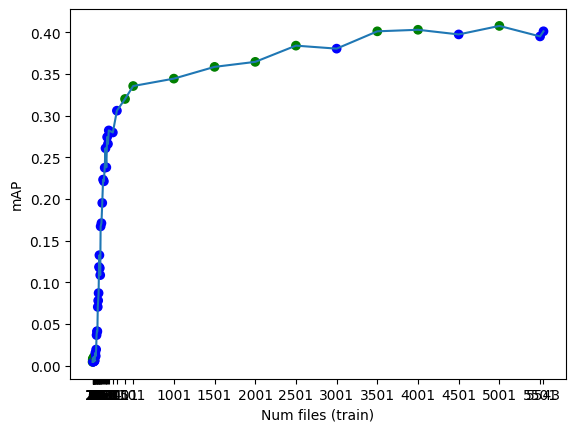

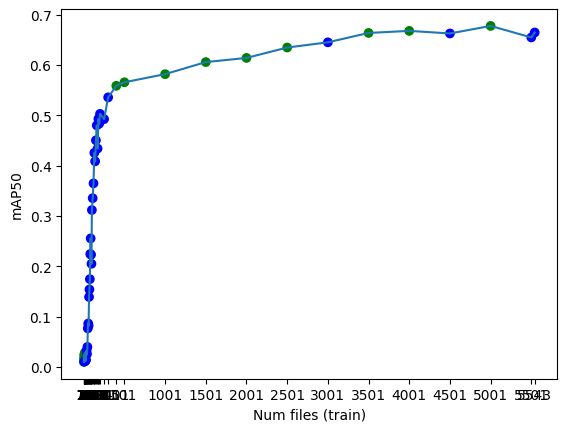

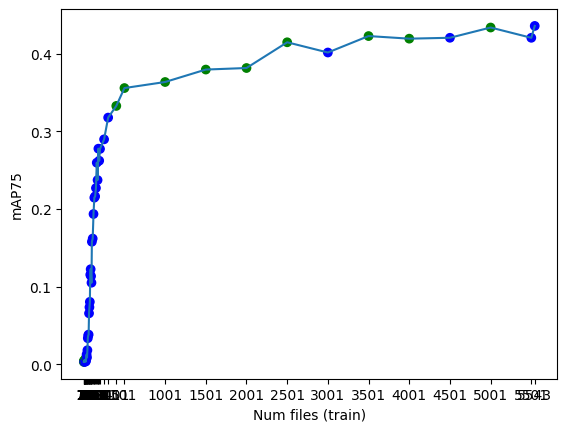

In [5]:
locale.getpreferredencoding = lambda: "UTF-8"

PATH_TO_MODEL = "/kaggle/working/yolov8m-seg.pt"
PATH_TO_YAML = "/kaggle/working/fire_smoke-9/data.yaml"
TRAIN_PERC = 0.8
TEST_PERC = 0.1
VAL_PERC = 0.1
KEEP_PERC = 1.0
PIECE_PERC = 0.05
ITERS = 5
FIB_FLAG = True
PREV_NUM = 50
THRESHOLD = 0.001

result_dict_base = dict()
result_dict_inc = dict()
color_dict_inc = dict()

exp_inc = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC)

# exp_inc.train_test_val_split(KEEP_PERC)
# cls_tl_dict, cls_fif_dict = exp_inc.take_piece(PIECE_PERC, FIB_FLAG)

# exp_inc.increm_learning(KEEP_PERC, ITERS, PIECE_PERC, FIB_FLAG, PREV_NUM, THRESHOLD)
# exp_inc.plot_ram_usage()

exp_inc.increm_learning_one_class('0', KEEP_PERC, ITERS, PIECE_PERC, FIB_FLAG, PREV_NUM, THRESHOLD)
exp_inc.plot_ram_usage()


### –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –±–∞–∑–æ–≤–æ–≥–æ –∏ –∏–Ω–∫—Ä–µ–º–µ–Ω—Ç–∞–ª—å–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è

locale.getpreferredencoding = lambda: "UTF-8"

PATH_TO_MODEL = "/kaggle/working/yolov8m-seg.pt"
PATH_TO_YAML = "/kaggle/working/feet-14/data.yaml"
TRAIN_PERC = 0.8
TEST_PERC = 0.1
VAL_PERC = 0.1
KEEP_PERC = 1.0
PIECE_PERC = 0.05
ITERS = 5

result_dict_base = dict()
result_dict_inc = dict()
color_dict_inc = dict()

exp_base = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC)
result_dict_base = exp_base.base_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_base.plot_ram_usage()
del(exp_base)

exp_inc = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC, 1, 1)
result_dict_inc, color_dict_inc = exp_inc.increm_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_inc.plot_ram_usage()

import math 

map_base_list = [j[0] for j in result_dict_base.values()]
map_inc_list = [j[0] for j in result_dict_inc.values()]
mse = 0
for map_base, map_inc in zip(map_base_list, map_inc_list):
    dev = (map_base - map_inc)
    mse += dev**2
print(f"MSE = {mse}\nRMSE = {math.sqrt(mse)}")

metrics_names = ("mAP","mAP50", "mAP75")
for i, metric in enumerate(metrics_names):
    plt.plot(list(result_dict_base.keys()),
             [j[i] for j in result_dict_base.values()],
             marker='o',
             color="green",
             linestyle='-',
             zorder=0,
             label = "–ë–∞–∑–æ–≤–æ–µ –æ–±—É—á–µ–Ω–∏–µ")
    
    plt.scatter(list(result_dict_inc.keys()),
                [j[i] for j in result_dict_inc.values()],
                color=list(color_dict_inc.values()),
                zorder=1)
    plt.plot(list(result_dict_inc.keys()),
             [j[i] for j in result_dict_inc.values()],
             linestyle='-',
             label = "–ò–Ω–∫—Ä–µ–º–µ–Ω—Ç–∞–ª—å–Ω–æ–µ –æ–±—É—á–µ–Ω–∏–µ")
    
    plt.ylabel(metric)
    plt.xlabel("Keep percent (%)")
    plt.legend()
    plt.show()

num_folders = 1 / PIECE_PERC
for folder in range(int(num_folders)):
    dir_path = f"temp_{folder+1}/train/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/train/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), '\n')
    
